In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
import copy
# model
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error,r2_score
# import sklearn.metrics.mean_absolute_percentage_error as mape
# import sklearn.mean_squared_error as mse
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler
from sklearn.preprocessing import MinMaxScaler, Normalizer
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV as cv
from sklearn.utils import shuffle

## Data Reading

### Initial data L（4train+2val）

In [3]:
data_truth = pd.read_excel('data/Initial data L.xlsx')

In [4]:
data_truth.head()

,formula,Mn,Co,Cu,Ga,Ge,Nb,Ni,Si,Sn,...,B,Fe,Ag,element_B,Sb,Cr,Re,alpha,t1,t2
0,Mn3.1Zn0.4Sn0.5N,3.1,0,0,0,0,0,0,0,0.5,...,0,0,0,2,0,0,0,-7.93,391,439
1,Mn3.1Zn0.5Sn0.4N,3.1,0,0,0,0,0,0,0,0.4,...,0,0,0,2,0,0,0,-25.30,313,371
2,Mn3.1Zn0.6Sn0.3N,3.1,0,0,0,0,0,0,0,0.3,...,0,0,0,2,0,0,0,-29.70,330,381
3,Mn3.2Zn0.4Sn0.4N,3.2,0,0,0,0,0,0,0,0.4,...,0,0,0,2,0,0,0,-9.91,357,413
4,Mn3.2Zn0.5Sn0.3N,3.2,0,0,0,0,0,0,0,0.3,...,0,0,0,2,0,0,0,-33.80,293,345


In [5]:
data_truth = data_truth.fillna(0)
print(data_truth.isnull().any().any())
data_truth = data_truth[['Mn', 'Co', 'Cu', 'Ga', 'Ge', 'Nb', 'Ni', 'Si', 'Sn', 'Zn',
       'N', 'C', 'B', 'Fe', 'Ag', 'element_B','Sb', 'Cr', 'Re','alpha','t1',
       't2']]

False


这里选着不同的初始数据。选取理由是调参

In [78]:
data_truth_val = data_truth.iloc[[1,2]]
data_truth_val.shape

(2, 22)

In [8]:
data_truth_train = data_truth.iloc[[0,3,4,5]]
data_truth_train.shape

(4, 22)

In [9]:
data_truth.head()

,Mn,Co,Cu,Ga,Ge,Nb,Ni,Si,Sn,Zn,...,B,Fe,Ag,element_B,Sb,Cr,Re,alpha,t1,t2
0,3.1,0,0,0,0,0,0,0,0.5,0.4,...,0,0,0,2,0,0,0,-7.93,391,439
1,3.1,0,0,0,0,0,0,0,0.4,0.5,...,0,0,0,2,0,0,0,-25.30,313,371
2,3.1,0,0,0,0,0,0,0,0.3,0.6,...,0,0,0,2,0,0,0,-29.70,330,381
3,3.2,0,0,0,0,0,0,0,0.4,0.4,...,0,0,0,2,0,0,0,-9.91,357,413
4,3.2,0,0,0,0,0,0,0,0.3,0.5,...,0,0,0,2,0,0,0,-33.80,293,345


### data pool U

In [11]:
data_ = pd.read_excel('data/external data pool U.xlsx')

In [12]:
data_.head()

,formula,Mn,Co,Cu,Ga,Ge,Nb,Ni,Si,Sn,...,element_C,t1,t2,deltaT,alpha,T1_label,alpha_label,Sb,Cr,Re
0,Mn3Cu0.53Ge0.47N,3.00,0,0.53,0.0,0.47,0.0,0.0,0.0,0.0,...,1,267.0,342.00,75.0,-16.0,1,0,NaN,NaN,NaN
1,Mn3Cu0.5Ge0.5N,3.00,0,0.50,0.0,0.50,0.0,0.0,0.0,0.0,...,1,280.0,365.00,85.0,-12.0,2,0,NaN,NaN,NaN
2,Mn3Ga0.7Ge0.3N0.88C0.12,3.00,0,0.00,0.7,0.30,0.0,0.0,0.0,0.0,...,2,197.0,319.00,122.0,-18.0,0,0,NaN,NaN,NaN
3,Mn3Ga0.5Ge0.4Mn0.1N,3.10,0,0.00,0.5,0.40,0.0,0.0,0.0,0.0,...,1,327.9,392.65,65.5,-3.0,3,0,NaN,NaN,NaN
4,(Mn0.96Fe0.04)3Zn0.5Ge0.5N,2.88,0,0.00,0.0,0.50,0.0,0.0,0.0,0.0,...,1,316.0,386.00,70.0,-25.0,2,1,NaN,NaN,NaN


In [13]:
data_.shape

(123, 28)

In [14]:
data_ = data_.fillna(0)
print(data_.isnull().any().any())
data_ = data_[['Mn', 'Co', 'Cu', 'Ga', 'Ge', 'Nb', 'Ni', 'Si', 'Sn', 'Zn',
       'N', 'C', 'B', 'Fe', 'Ag', 'element_B','Sb', 'Cr', 'Re','alpha','t1',
       't2']]

False


## Feature engineering

In [15]:
target1, target2, target3 = data_['alpha'],data_['t1'],data_['t2']
x = data_[['Mn', 'Co', 'Cu', 'Ga', 'Ge', 'Nb', 'Ni', 'Si', 'Sn', 'Zn',
       'N', 'C', 'B', 'Fe', 'Ag', 'element_B','Sb', 'Cr', 'Re']]

In [16]:
# data = data.iloc[:,1:20]

### Normalization for feature matrix

In [17]:
from sklearn import preprocessing
standar = preprocessing.StandardScaler()
x = pd.DataFrame(standar.fit_transform(x))
x.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.140439,0.0,0.619414,-0.450365,1.713440,-0.225509,-0.206202,-0.337151,-0.607045,-0.423725,0.388960,-0.383765,-0.158114,-0.090536,-0.336294,-0.500521,-0.258841,-0.146124,-0.139058
1,-0.140439,0.0,0.521360,-0.450365,1.876351,-0.225509,-0.206202,-0.337151,-0.607045,-0.423725,0.388960,-0.383765,-0.158114,-0.090536,-0.336294,-0.500521,-0.258841,-0.146124,-0.139058
2,-0.140439,0.0,-1.112872,2.329305,0.790275,-0.225509,-0.206202,-0.337151,-0.607045,-0.423725,-1.862432,1.976389,-0.158114,-0.090536,-0.336294,-0.500521,-0.258841,-0.146124,-0.139058
3,0.846645,0.0,-1.112872,1.535113,1.333313,-0.225509,-0.206202,-0.337151,-0.607045,-0.423725,0.388960,-0.383765,-0.158114,-0.090536,-0.336294,1.485417,-0.258841,-0.146124,-0.139058
4,-1.324939,0.0,-1.112872,-0.450365,1.876351,-0.225509,-0.206202,-0.337151,-0.607045,2.249001,0.388960,-0.383765,-0.158114,11.045361,-0.336294,-0.500521,-0.258841,-0.146124,-0.139058


### Verify the normal distribution of target

In [18]:
def max_min(column):
    print(column.min(),column.max())
    return (column - column.min()) / (column.max() - column.min())

0      342.00
1      365.00
2      319.00
3      392.65
4      386.00
        ...  
118    375.00
119    344.12
120    418.63
121    337.25
122    325.00
Name: t2, Length: 123, dtype: float64


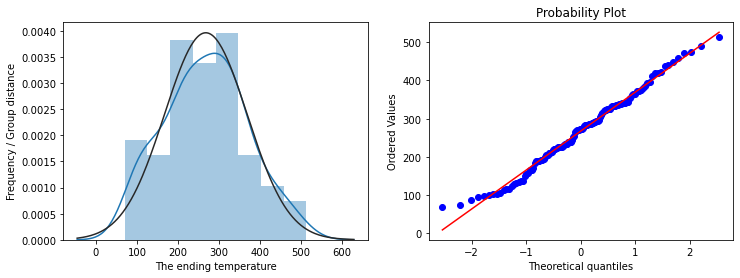

In [19]:
# target1 = np.log(target1)
# target1 = target1 ** 0.5
# target1 = target1 **2
print(target3)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(target3.dropna(),fit=stats.norm,);
plt.ylabel("Frequency / Group distance")
plt.xlabel('The ending temperature')
plt.subplot(1,2,2)
_ = stats.probplot(target3.dropna(),plot=plt)

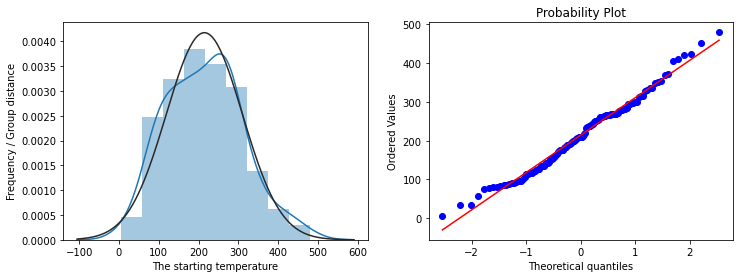

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(target2.dropna(),fit=stats.norm,);
plt.ylabel("Frequency / Group distance")
plt.xlabel('The starting temperature')
plt.subplot(1,2,2)
_ = stats.probplot(target2.dropna(),plot=plt)

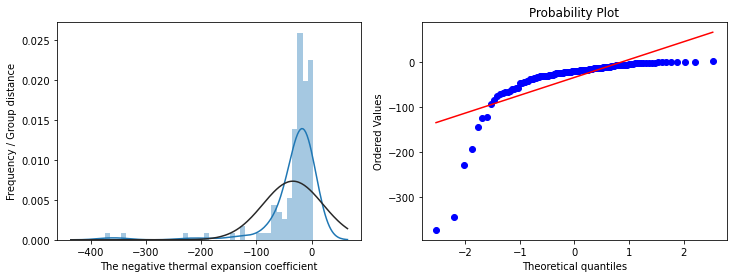

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(target1.dropna(),fit=stats.norm,);
plt.ylabel("Frequency / Group distance")
plt.xlabel('The negative thermal expansion coefficient')
plt.subplot(1,2,2)
_ = stats.probplot(target1.dropna(),plot=plt)

### kfold function

In [22]:
def mean_relative_error(y_true,y_pred):
    relative_error = np.average(abs(y_true - y_pred) / abs(y_true), axis=0)
    return relative_error

def kfold(model,X,y):
   # 5折交叉验证
    Folds=3
    kf = KFold(n_splits = Folds,shuffle=True, random_state = 300)
    # 记录训练和预测MSE
    # 记录训练和预测r2
    train_r2_ = []
    test_r2_ = []

    # 线下训练预测
    for (train, test) in (kf.split(X,y)):

       # 切分训练集和预测集
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        # 训练模型
        model.fit(X_train,y_train)

        # 训练集预测 测试集预测
        y_train_KFold_predict = model.predict(X_train)
        y_test_KFold_predict = model.predict(X_test) 

        #相对误差
        # train_r2 = mean_relative_error(y_train,y_train_KFold_predict)
        # test_r2 = mean_relative_error(y_test,y_test_KFold_predict)
        
        #R2
        train_r2 = r2_score(y_train,y_train_KFold_predict)
        test_r2 = r2_score(y_test,y_test_KFold_predict)

        train_r2_.append(train_r2)
        test_r2_.append(test_r2)

    mean_r2_train = np.mean(train_r2_)
    mean_r2_test = np.mean(test_r2_)
    # print('------', 'train_r2',1- mean_r2_train, '------')
    # print('------', 'test_r2',1- mean_r2_test, '------')
    
    return(mean_r2_train,mean_r2_test)

In [66]:
def kfold_relative_error(model,X,y):
   # 5折交叉验证
    Folds = 3
    kf = KFold(n_splits = Folds,shuffle=True, random_state = 300)
    # 记录训练和预测MSE
    # 记录训练和预测r2
    train_r2_ = []
    test_r2_ = []

    # 线下训练预测
    for (train, test) in (kf.split(X,y)):

       # 切分训练集和预测集
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        # 训练模型
        model.fit(X_train,y_train)

        # 训练集预测 测试集预测
        y_train_KFold_predict = model.predict(X_train)
        y_test_KFold_predict = model.predict(X_test) 

        #相对误差
#         train_r2 =  mape(y_train,y_train_KFold_predict)
#         test_r2 =  mape(y_test,y_test_KFold_predict)

        train_r2 = 1- mean_relative_error(y_train,y_train_KFold_predict)
        test_r2 = 1 - mean_relative_error(y_test,y_test_KFold_predict)
        
        #R2
#         train_r2 = r2_score(y_train,y_train_KFold_predict)
#         test_r2 = r2_score(y_test,y_test_KFold_predict)
        
        #mse
#         train_r2 = abs(y_train-y_train_KFold_predict).sum() / len(y_train)
#         test_r2 = abs(y_test-y_test_KFold_predict).sum() / len(y_train)

        train_r2_.append(train_r2)
        test_r2_.append(test_r2)

    mean_r2_train = np.mean(train_r2_)
    mean_r2_test = np.mean(test_r2_)
    # print('------', 'train_r2',1- mean_r2_train, '------')
    # print('------', 'test_r2',1- mean_r2_test, '------')
    
    return(mean_r2_train,mean_r2_test)

In [24]:
y = target3

In [25]:
# 用svr跑一下
train_scores = []
test_scores = []
for i in range(1,2000,5):
    clf = SVR(C=i)
    train, test = kfold_relative_error(clf,x,y)
    # train, test = kfold(clf,x1,y)
    train_scores.append(train)
    test_scores.append(test)
score = np.max(test_scores)
best_c = test_scores.index(score)*5+1
print("svr score",score,"best_c",best_c)

svr score 0.8884933192698415 best_c 1931


In [26]:
clf = SVR(C=best_c)
clf.fit(x,y)
# x_val = pd.DataFrame(standar.fit_transform(data_truth_val[:19]))
x_val = data_truth_val.iloc[:,:19]
print(x_val)
y_val_pre = clf.predict(x_val)
y_val = data_truth_val.iloc[:,-1] 
print(y_val_pre)
print(y_val)
print(r2_score(y_val,y_val_pre))
print((abs(y_val - y_val_pre) / y_val).sum() / len(y_val))

    Mn  Co  Cu  Ga  Ge  Nb  Ni  Si   Sn   Zn  N  C  B  Fe  Ag  element_B  Sb  \
4  3.2   0   0   0   0   0   0   0  0.3  0.5  1  0  0   0   0          2   0   
5  3.2   0   0   0   0   0   0   0  0.2  0.6  1  0  0   0   0          2   0   

   Cr  Re  
4   0   0  
5   0   0  
[231.68348007 234.0029275 ]
4    345
5    309
Name: t2, dtype: int64
-27.49567063504568
0.2855813267149276


In [27]:
# 用gbdt跑一下
train_scores = []
test_scores = []
for i in range(1,1000,10):
    clf = GradientBoostingRegressor(n_estimators=i)
    train, test = kfold_relative_error(clf,x,y)
    train_scores.append(train)
    test_scores.append(test)
print("score",np.min(test_scores))

score 0.5959052903993538


In [28]:
train_scores = []
test_scores = []
for i in range(1,1000,10):
    clf = XGBRegressor(max_depth=4,n_estimators=i,random_state=2021)
    train, test = kfold_relative_error(clf,x,y)
    train_scores.append(train)
    test_scores.append(test)
print("test_scores",np.min(test_scores))

test_scores 0.3006008018454076


### score function

构建筛选集，按每个epoch为30条，加入到原始的数据中，接着计算得分，然后筛选是不是需要的数据。按主动学习基于减小误差的查询，流程：
* 1.选择一个损失函数用来评估错误率
* 2.将未标注样本输入，如果r2连续下降就停止

In [29]:
# x = pd.DataFrame(standar.fit_transform(data_truth.iloc[:,0:19]))
# y = data_truth.iloc[:,19]
# svr = SVR()
# y_pre = svr.fit(x)
# print(y_pre)

In [30]:
def model_choose(model_name,x,y):
    ## 可以写成多个模型的选择
    for i in range(1,1000,1):
        clf = SVR(C=i)
        train, test = kfold_relative_error(clf,x,y)
        # train, test = kfold(clf,x1,y)
        train_scores.append(train)
        test_scores.append(test)
    
    score = np.max(test_scores)
    best_c = test_scores.index(score)
    return score,best_c

In [31]:
def scores(epoch):
    x = epoch.iloc[:,0:19]
    y = epoch.iloc[:,19]
    standar = preprocessing.StandardScaler()
    x1 = pd.DataFrame(standar.fit_transform(x))  # 对x做正则化,这里没有对y做任何处理
    y = y/10
    train_scores = []
    test_scores = []
    model_choose(SVR,x1,y)
    for i in range(1,1000,1):
        clf = SVR(C=i)
        train, test = kfold_relative_error(clf,x1,y)
        # train, test = kfold(clf,x1,y)
        train_scores.append(train)
        test_scores.append(test)
    score = np.max(test_scores)
    best_c = test_scores.index(score)
    return score

## ALDS

### Building data pool U

以data_truth为基准，遍历120条的数据，每次选着使得r2上升最大的数据放入数据集中

In [32]:
def active_learning(epoch, data, n):
    '''实现主动学习的思想，从数据池中拿入query，计算r2'''
    test = []
    index = []
    for i in range(0,len(data),n):
        data_ = data.iloc[i:i+n,]
        epoch_test = pd.concat([epoch,data_],axis=0)
        score = scores(epoch_test)
        test.append(score)

    #     if float(score) > 0.360:
    #         epoch = epoch_test
    # print(np.max(test))
    # print(test.index(np.max(test)))
    
    best_score = np.max(test)
    index = test.index(np.max(test))*n
    
    return best_score, index

In [33]:
best_score_last = 0.0
score_list = []    # 保存每次遍历的最好分数
index_list = []    # 保存每次遍历的最好数据集

def choose_data(epoch, data, n):
    '''
    输入：原本的数据集，数据池，窗口大小
    输出：挑选后的数据，最好的成绩
    先给数据池的每个窗口打分，选着最好的成绩，保存index和score
    '''
    global score_list
    global best_score_last
    global index_list
    
    print('|  选出数据池的index  |  数据池剩余   |   the score   |')
    
    i=0.0
    data_all = copy.deepcopy(data)
    
    while(len(data)/n>=1):
        ## 选出当前池里面分数最高的n列
        test_scores = []
        index = []
        for i in range(0,len(data),n):
            ## 因为是按序列取的，i的取值是0~len(data)，而现在是要取data.index里的值
            idx = list(np.array(data.index))  #取出当前的index
            idx = np.array(idx[i:i+n])        #按窗口依次取出n列数据
            if len(idx) == n :
                # print(idx)
                data_ = data.loc[idx]
                # print(data_)
                epoch_test = pd.concat([epoch,data_],axis=0)
                score = scores(epoch_test)
                if np.isnan(score):
                    test_scores.append(0)
                else:
                    test_scores.append(score)
                index.append(idx)                 #保存这些列的数据
        
        best_score = np.max(test_scores)
        # print(best_score)
        index_max = index[test_scores.index(best_score)] 
        # print(index_max)


        score_list.append(best_score)
        index_list.append(np.array(index_max))


        index_ = np.array(index_max)
        # 会和前面的别的index弄混
        epoch = pd.concat([epoch,data.loc[index_]],axis=0)  # 放入使评价函数最优的数据
        data = data.drop(index=index_,axis=0)     # 数据池里面拿出数据

        print('|---',index_,'---|---',len(data),'---|---','%.3f' % best_score,'---|')
        
        
        if(len(score_list)>4):
            if(score_list[-1]<score_list[-2]<score_list[-3]<score_list[-4]):  #score连续下降4次时跳出循环
                break;
                
    ## 把效果最好的score的index取出来
    # epoch = epoch.drop([0:len(data_truth_train)],axis=0)
    best_epoch = data_truth_train    # 初始4条
    bs = np.max(score_list)          # 最好成绩
    bs_ = score_list.index(bs)       # 最好成绩的idx
    for i in range(0,bs_+1):         # 出现最好成绩为止所有选出来的数据
        bs_idx = np.array(index_list[i])
        print(bs_idx)
        best_epoch = pd.concat([best_epoch,data_all.loc[bs_idx]],axis=0)   # 把数据池筛选的数据拿出来

    plt.plot(score_list, color='green',label="score_list")
    plt.title("score VS loop")
    plt.show()
    # print(index_drop)

    return best_epoch, bs

### Data screaning

In [34]:
data = data_.copy()

In [35]:
epoch = data_truth_train

In [36]:
len(data)

123

----现在进行第 0 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [36  8 41] ---|--- 120 ---|--- 0.637 ---|
|--- [100  95 119] ---|--- 117 ---|--- 0.647 ---|
|--- [ 79 102  38] ---|--- 114 ---|--- 0.581 ---|
|--- [ 89 106  57] ---|--- 111 ---|--- 0.727 ---|
|--- [ 0 37 93] ---|--- 108 ---|--- 0.746 ---|
|--- [ 22  32 107] ---|--- 105 ---|--- 0.766 ---|
|--- [72 65 88] ---|--- 102 ---|--- 0.774 ---|
|--- [  1   5 112] ---|--- 99 ---|--- 0.753 ---|
|--- [ 53  97 101] ---|--- 96 ---|--- 0.782 ---|
|--- [67 94 14] ---|--- 93 ---|--- 0.786 ---|
|--- [90 28  3] ---|--- 90 ---|--- 0.791 ---|
|--- [ 78 105 103] ---|--- 87 ---|--- 0.768 ---|
|--- [108  10  77] ---|--- 84 ---|--- 0.683 ---|
|--- [ 58  59 109] ---|--- 81 ---|--- 0.587 ---|
[36  8 41]
[100  95 119]
[ 79 102  38]
[ 89 106  57]
[ 0 37 93]
[ 22  32 107]
[72 65 88]
[  1   5 112]
[ 53  97 101]
[67 94 14]
[90 28  3]


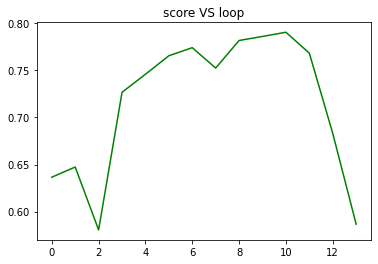

----现在进行第 1 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [ 49 108 112] ---|--- 120 ---|--- 0.579 ---|
|--- [90 80 51] ---|--- 117 ---|--- 0.537 ---|
|--- [107  62  77] ---|--- 114 ---|--- 0.493 ---|
|--- [10 36  1] ---|--- 111 ---|--- 0.511 ---|
|--- [105  64  63] ---|--- 108 ---|--- 0.574 ---|
|--- [ 91  57 119] ---|--- 105 ---|--- 0.556 ---|
|--- [47 33 88] ---|--- 102 ---|--- 0.535 ---|
|--- [121  97  21] ---|--- 99 ---|--- 0.582 ---|
|--- [59 32 95] ---|--- 96 ---|--- 0.620 ---|
|--- [92 46 53] ---|--- 93 ---|--- 0.645 ---|
|--- [103 115  70] ---|--- 90 ---|--- 0.655 ---|
|--- [ 37  82 117] ---|--- 87 ---|--- 0.655 ---|
|--- [96 50 83] ---|--- 84 ---|--- 0.634 ---|
|--- [ 3 18  7] ---|--- 81 ---|--- 0.655 ---|
|--- [113 104  30] ---|--- 78 ---|--- 0.623 ---|
|--- [101   6   9] ---|--- 75 ---|--- 0.633 ---|
|--- [ 56  31 120] ---|--- 72 ---|--- 0.633 ---|
|--- [28 13 19] ---|--- 69 ---|--- 0.560 ---|
|--- [  0  29 100] ---|--- 66 ---|--- 0.575 ---|
|--- [22 65 12] ---|

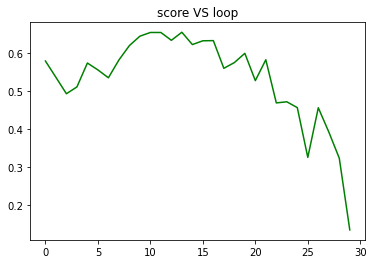

----现在进行第 2 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [121 100 120] ---|--- 120 ---|--- 0.608 ---|
|--- [ 35 104  79] ---|--- 117 ---|--- 0.648 ---|
|--- [47 23 46] ---|--- 114 ---|--- 0.631 ---|
|--- [30 84 94] ---|--- 111 ---|--- 0.663 ---|
|--- [38 62 36] ---|--- 108 ---|--- 0.728 ---|
|--- [57 48 32] ---|--- 105 ---|--- 0.741 ---|
|--- [25  6 33] ---|--- 102 ---|--- 0.741 ---|
|--- [59 28 61] ---|--- 99 ---|--- 0.672 ---|
|--- [ 58 119  99] ---|--- 96 ---|--- 0.596 ---|
[121 100 120]
[ 35 104  79]
[47 23 46]
[30 84 94]
[38 62 36]
[57 48 32]


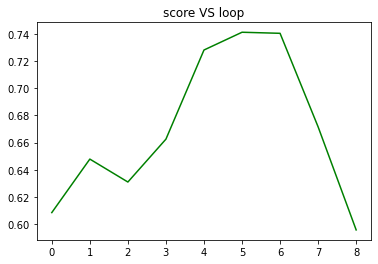

----现在进行第 3 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [68 80 84] ---|--- 120 ---|--- 0.616 ---|
|--- [47 30 37] ---|--- 117 ---|--- 0.661 ---|
|--- [22 99 32] ---|--- 114 ---|--- 0.568 ---|
|--- [106  35 113] ---|--- 111 ---|--- 0.653 ---|
|--- [ 62 105   4] ---|--- 108 ---|--- 0.648 ---|
|--- [ 98 107  95] ---|--- 105 ---|--- 0.619 ---|
|--- [ 7 82 57] ---|--- 102 ---|--- 0.729 ---|
|--- [38 97 89] ---|--- 99 ---|--- 0.693 ---|
|--- [60  0 31] ---|--- 96 ---|--- 0.688 ---|
|--- [56  1 33] ---|--- 93 ---|--- 0.676 ---|
[68 80 84]
[47 30 37]
[22 99 32]
[106  35 113]
[ 62 105   4]
[ 98 107  95]
[ 7 82 57]


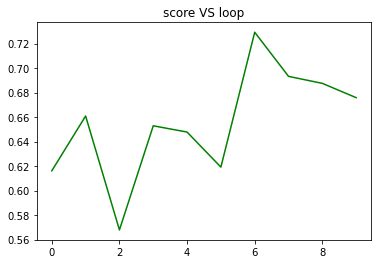

----现在进行第 4 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [ 37  86 103] ---|--- 120 ---|--- 0.663 ---|
|--- [28 47 32] ---|--- 117 ---|--- 0.695 ---|
|--- [  0 101  46] ---|--- 114 ---|--- 0.611 ---|
|--- [68 56 38] ---|--- 111 ---|--- 0.670 ---|
|--- [ 57  82 106] ---|--- 108 ---|--- 0.606 ---|
|--- [ 27 105  97] ---|--- 105 ---|--- 0.659 ---|
|--- [ 90  94 115] ---|--- 102 ---|--- 0.698 ---|
|--- [22  9 83] ---|--- 99 ---|--- 0.692 ---|
|--- [ 18  50 108] ---|--- 96 ---|--- 0.683 ---|
|--- [ 33 114 102] ---|--- 93 ---|--- 0.673 ---|
[ 37  86 103]
[28 47 32]
[  0 101  46]
[68 56 38]
[ 57  82 106]
[ 27 105  97]
[ 90  94 115]


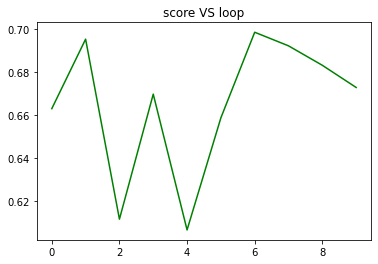

----现在进行第 5 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [41 88 22] ---|--- 120 ---|--- 0.590 ---|
|--- [25 83 98] ---|--- 117 ---|--- 0.644 ---|
|--- [117  35  49] ---|--- 114 ---|--- 0.585 ---|
|--- [57 63 79] ---|--- 111 ---|--- 0.604 ---|
|--- [12 94 48] ---|--- 108 ---|--- 0.679 ---|
|--- [ 62  95 103] ---|--- 105 ---|--- 0.741 ---|
|--- [121  69 108] ---|--- 102 ---|--- 0.765 ---|
|--- [80 85  2] ---|--- 99 ---|--- 0.715 ---|
|--- [ 17 102  38] ---|--- 96 ---|--- 0.718 ---|
|--- [92 32 14] ---|--- 93 ---|--- 0.699 ---|
|--- [ 46 114  97] ---|--- 90 ---|--- 0.674 ---|
|--- [18 96 36] ---|--- 87 ---|--- 0.646 ---|
[41 88 22]
[25 83 98]
[117  35  49]
[57 63 79]
[12 94 48]
[ 62  95 103]
[121  69 108]


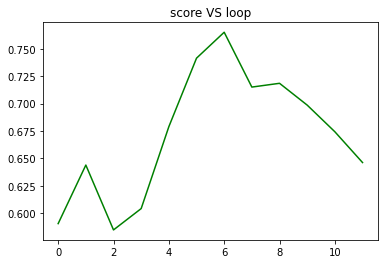

----现在进行第 6 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [98 46 84] ---|--- 120 ---|--- 0.626 ---|
|--- [121 119 100] ---|--- 117 ---|--- 0.699 ---|
|--- [  8 105  56] ---|--- 114 ---|--- 0.705 ---|
|--- [28 14 41] ---|--- 111 ---|--- 0.710 ---|
|--- [107  32  82] ---|--- 108 ---|--- 0.673 ---|
|--- [60 37  7] ---|--- 105 ---|--- 0.680 ---|
|--- [86 99 90] ---|--- 102 ---|--- 0.652 ---|
|--- [101   9  88] ---|--- 99 ---|--- 0.677 ---|
|--- [  2  64 114] ---|--- 96 ---|--- 0.648 ---|
|--- [ 13  25 117] ---|--- 93 ---|--- 0.655 ---|
|--- [106  91  12] ---|--- 90 ---|--- 0.653 ---|
|--- [ 78  67 108] ---|--- 87 ---|--- 0.644 ---|
|--- [89 65 95] ---|--- 84 ---|--- 0.619 ---|
[98 46 84]
[121 119 100]
[  8 105  56]
[28 14 41]


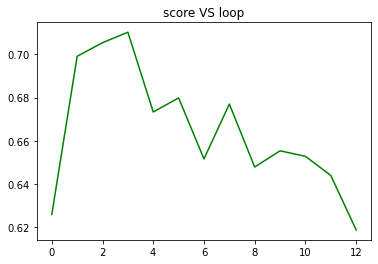

----现在进行第 7 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [117   2  84] ---|--- 120 ---|--- 0.649 ---|
|--- [113  46  95] ---|--- 117 ---|--- 0.738 ---|
|--- [119  49  85] ---|--- 114 ---|--- 0.722 ---|
|--- [28  5 47] ---|--- 111 ---|--- 0.738 ---|
|--- [50 98 36] ---|--- 108 ---|--- 0.657 ---|
|--- [ 37  79 111] ---|--- 105 ---|--- 0.697 ---|
|--- [102 112   4] ---|--- 102 ---|--- 0.747 ---|
|--- [62  7 38] ---|--- 99 ---|--- 0.709 ---|
|--- [ 51 101 105] ---|--- 96 ---|--- 0.698 ---|
|--- [114 108 115] ---|--- 93 ---|--- 0.676 ---|
[117   2  84]
[113  46  95]
[119  49  85]
[28  5 47]
[50 98 36]
[ 37  79 111]
[102 112   4]


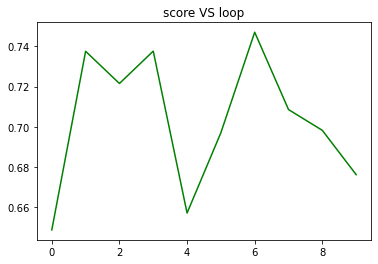

----现在进行第 8 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [32 48 49] ---|--- 120 ---|--- 0.632 ---|
|--- [114  97  37] ---|--- 117 ---|--- 0.715 ---|
|--- [ 35  31 106] ---|--- 114 ---|--- 0.618 ---|
|--- [69 95  5] ---|--- 111 ---|--- 0.751 ---|
|--- [107  51  94] ---|--- 108 ---|--- 0.736 ---|
|--- [57 64 84] ---|--- 105 ---|--- 0.715 ---|
|--- [59 96 28] ---|--- 102 ---|--- 0.678 ---|
[32 48 49]
[114  97  37]
[ 35  31 106]
[69 95  5]


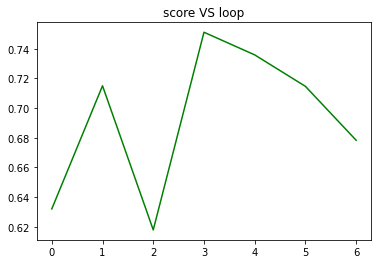

----现在进行第 9 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [87 34 33] ---|--- 120 ---|--- 0.656 ---|
|--- [108  53   9] ---|--- 117 ---|--- 0.289 ---|
|--- [ 52 113  12] ---|--- 114 ---|--- 0.171 ---|
|--- [48 80  8] ---|--- 111 ---|--- 0.099 ---|
|--- [ 0 70 83] ---|--- 108 ---|--- 0.109 ---|
|--- [ 84  13 103] ---|--- 105 ---|--- 0.137 ---|
|--- [32 65 63] ---|--- 102 ---|--- 0.274 ---|
|--- [60 90 31] ---|--- 99 ---|--- 0.185 ---|
|--- [112 117   5] ---|--- 96 ---|--- 0.336 ---|
|--- [37 89  7] ---|--- 93 ---|--- 0.495 ---|
|--- [111   1   3] ---|--- 90 ---|--- 0.404 ---|
|--- [82 49 30] ---|--- 87 ---|--- 0.312 ---|
|--- [120 121  92] ---|--- 84 ---|--- 0.460 ---|
|--- [ 14  95 116] ---|--- 81 ---|--- 0.449 ---|
|--- [61 47 72] ---|--- 78 ---|--- 0.372 ---|
|--- [119  64  99] ---|--- 75 ---|--- 0.111 ---|
[87 34 33]


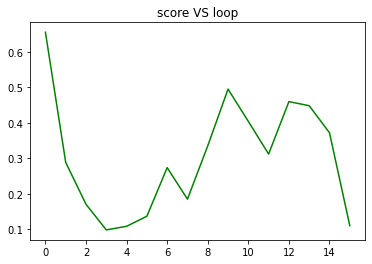

----现在进行第 10 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [ 0 56 24] ---|--- 120 ---|--- 0.641 ---|
|--- [88 12 41] ---|--- 117 ---|--- 0.583 ---|
|--- [ 14 106  84] ---|--- 114 ---|--- 0.585 ---|
|--- [120  25  62] ---|--- 111 ---|--- 0.725 ---|
|--- [ 55 100  69] ---|--- 108 ---|--- 0.667 ---|
|--- [ 85 107  77] ---|--- 105 ---|--- 0.685 ---|
|--- [23 91 50] ---|--- 102 ---|--- 0.643 ---|
|--- [ 51 121  33] ---|--- 99 ---|--- 0.606 ---|
|--- [111   8  28] ---|--- 96 ---|--- 0.627 ---|
|--- [ 38  63 102] ---|--- 93 ---|--- 0.608 ---|
|--- [104 103  49] ---|--- 90 ---|--- 0.647 ---|
|--- [37 52  4] ---|--- 87 ---|--- 0.631 ---|
|--- [65 90 19] ---|--- 84 ---|--- 0.571 ---|
|--- [59 18 89] ---|--- 81 ---|--- 0.582 ---|
|--- [ 72 110 112] ---|--- 78 ---|--- 0.608 ---|
|--- [ 48 114  60] ---|--- 75 ---|--- 0.615 ---|
|--- [ 9 68 10] ---|--- 72 ---|--- 0.657 ---|
|--- [39 36 17] ---|--- 69 ---|--- 0.601 ---|
|--- [97 92 32] ---|--- 66 ---|--- 0.555 ---|
|--- [ 16 105  95] ---

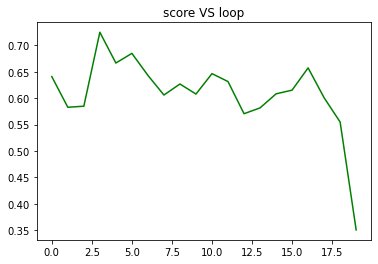

----现在进行第 11 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [115  50  99] ---|--- 120 ---|--- 0.666 ---|
|--- [28 86 80] ---|--- 117 ---|--- 0.744 ---|
|--- [ 8 64 85] ---|--- 114 ---|--- 0.596 ---|
|--- [ 48  56 113] ---|--- 111 ---|--- 0.615 ---|
|--- [117  22  84] ---|--- 108 ---|--- 0.662 ---|
|--- [27 53 49] ---|--- 105 ---|--- 0.627 ---|
|--- [112  63  47] ---|--- 102 ---|--- 0.703 ---|
|--- [31 10 57] ---|--- 99 ---|--- 0.676 ---|
|--- [ 82  35 106] ---|--- 96 ---|--- 0.674 ---|
|--- [67 70 96] ---|--- 93 ---|--- 0.723 ---|
|--- [102  60  89] ---|--- 90 ---|--- 0.682 ---|
|--- [105  65  58] ---|--- 87 ---|--- 0.672 ---|
|--- [33 79 41] ---|--- 84 ---|--- 0.651 ---|
[115  50  99]
[28 86 80]


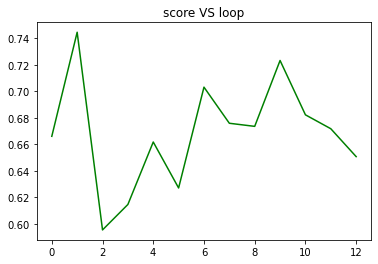

----现在进行第 12 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [85 36  8] ---|--- 120 ---|--- 0.646 ---|
|--- [99 84 55] ---|--- 117 ---|--- 0.740 ---|
|--- [114  35  17] ---|--- 114 ---|--- 0.584 ---|
|--- [108  81   1] ---|--- 111 ---|--- 0.613 ---|
|--- [38 64 59] ---|--- 108 ---|--- 0.553 ---|
|--- [120  80  49] ---|--- 105 ---|--- -0.045 ---|
|--- [ 48  90 111] ---|--- 102 ---|--- 0.535 ---|
|--- [97 50 58] ---|--- 99 ---|--- 0.616 ---|
|--- [ 5 16 79] ---|--- 96 ---|--- 0.528 ---|
|--- [22 51 56] ---|--- 93 ---|--- 0.577 ---|
|--- [ 95  53 117] ---|--- 90 ---|--- 0.562 ---|
|--- [ 72 121  25] ---|--- 87 ---|--- 0.586 ---|
|--- [70 30 67] ---|--- 84 ---|--- 0.578 ---|
|--- [ 98 115  19] ---|--- 81 ---|--- 0.666 ---|
|--- [107  94 116] ---|--- 78 ---|--- 0.613 ---|
|--- [60 41 93] ---|--- 75 ---|--- 0.604 ---|
|--- [110 100  82] ---|--- 72 ---|--- 0.620 ---|
|--- [32 74 88] ---|--- 69 ---|--- 0.575 ---|
|--- [102  10  28] ---|--- 66 ---|--- 0.504 ---|
|--- [ 29 101  77] --

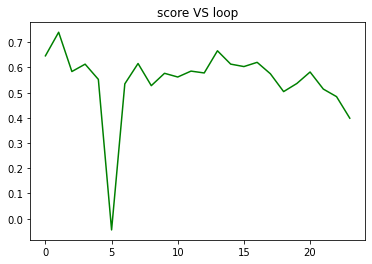

----现在进行第 13 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [30 59 24] ---|--- 120 ---|--- 0.686 ---|
|--- [100  79 122] ---|--- 117 ---|--- 0.663 ---|
|--- [ 67 106  82] ---|--- 114 ---|--- 0.419 ---|
|--- [105  88   0] ---|--- 111 ---|--- 0.522 ---|
|--- [96 94 72] ---|--- 108 ---|--- 0.603 ---|
|--- [ 10 103  23] ---|--- 105 ---|--- 0.571 ---|
|--- [21 57 33] ---|--- 102 ---|--- 0.504 ---|
|--- [89 65 97] ---|--- 99 ---|--- 0.572 ---|
|--- [117  77  36] ---|--- 96 ---|--- 0.598 ---|
|--- [ 7 54 92] ---|--- 93 ---|--- 0.651 ---|
|--- [63 38  3] ---|--- 90 ---|--- 0.626 ---|
|--- [ 25 107  50] ---|--- 87 ---|--- 0.601 ---|
|--- [ 48 120  90] ---|--- 84 ---|--- 0.615 ---|
|--- [108  39  19] ---|--- 81 ---|--- 0.633 ---|
|--- [32 46 28] ---|--- 78 ---|--- 0.487 ---|
|--- [85 14 56] ---|--- 75 ---|--- 0.505 ---|
|--- [64  1 40] ---|--- 72 ---|--- 0.548 ---|
|--- [86 83 62] ---|--- 69 ---|--- 0.551 ---|
|--- [58 34  5] ---|--- 66 ---|--- 0.567 ---|
|--- [ 41   2 114] ---|--- 6

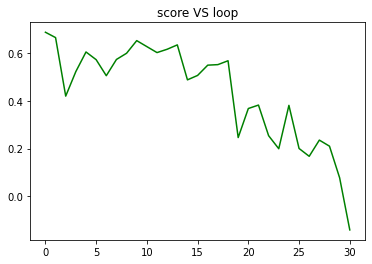

----现在进行第 14 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [115  50  36] ---|--- 120 ---|--- 0.603 ---|
|--- [106  49  25] ---|--- 117 ---|--- 0.627 ---|
|--- [107   9 112] ---|--- 114 ---|--- 0.602 ---|
|--- [ 0 84 78] ---|--- 111 ---|--- 0.662 ---|
|--- [ 41 101  21] ---|--- 108 ---|--- 0.637 ---|
|--- [23 10 82] ---|--- 105 ---|--- 0.672 ---|
|--- [105  83  88] ---|--- 102 ---|--- 0.713 ---|
|--- [  8 103  37] ---|--- 99 ---|--- 0.761 ---|
|--- [92 90 95] ---|--- 96 ---|--- 0.720 ---|
|--- [97 63 17] ---|--- 93 ---|--- 0.649 ---|
|--- [18 35 55] ---|--- 90 ---|--- 0.690 ---|
|--- [70 30 53] ---|--- 87 ---|--- 0.726 ---|
|--- [ 31  24 114] ---|--- 84 ---|--- 0.721 ---|
|--- [102 120 104] ---|--- 81 ---|--- 0.691 ---|
|--- [  4 100  77] ---|--- 78 ---|--- 0.702 ---|
|--- [ 19  13 113] ---|--- 75 ---|--- 0.630 ---|
|--- [121 111 122] ---|--- 72 ---|--- 0.643 ---|
|--- [58 27 72] ---|--- 69 ---|--- 0.639 ---|
|--- [98 76 60] ---|--- 66 ---|--- 0.625 ---|
|--- [ 34  46 119] 

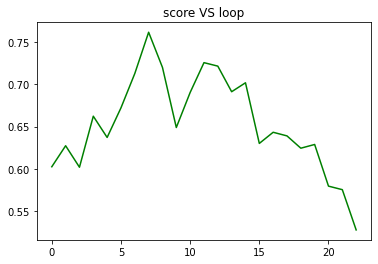

----现在进行第 15 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [32  8  0] ---|--- 120 ---|--- 0.647 ---|
|--- [119  53  55] ---|--- 117 ---|--- 0.696 ---|
|--- [108  38 116] ---|--- 114 ---|--- 0.739 ---|
|--- [112 114  41] ---|--- 111 ---|--- 0.704 ---|
|--- [83 23 97] ---|--- 108 ---|--- 0.563 ---|
|--- [12 94 59] ---|--- 105 ---|--- 0.671 ---|
|--- [100  96  85] ---|--- 102 ---|--- 0.645 ---|
|--- [ 69 107  88] ---|--- 99 ---|--- 0.683 ---|
|--- [105  22  21] ---|--- 96 ---|--- 0.698 ---|
|--- [ 86 122  78] ---|--- 93 ---|--- 0.667 ---|
|--- [89 48  5] ---|--- 90 ---|--- 0.643 ---|
|--- [46 64 14] ---|--- 87 ---|--- 0.714 ---|
|--- [90 68 51] ---|--- 84 ---|--- 0.678 ---|
|--- [54 72 35] ---|--- 81 ---|--- 0.660 ---|
|--- [  7  36 120] ---|--- 78 ---|--- 0.582 ---|
[32  8  0]
[119  53  55]
[108  38 116]


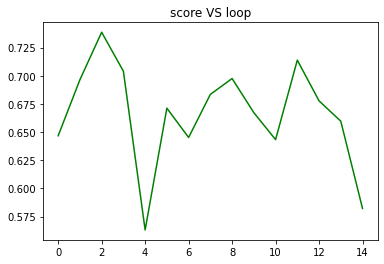

----现在进行第 16 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [ 38 115  85] ---|--- 120 ---|--- 0.680 ---|
|--- [  8 108  28] ---|--- 117 ---|--- 0.672 ---|
|--- [ 14  27 114] ---|--- 114 ---|--- 0.594 ---|
|--- [ 46  19 107] ---|--- 111 ---|--- 0.664 ---|
|--- [ 5 22  0] ---|--- 108 ---|--- 0.668 ---|
|--- [56 32 17] ---|--- 105 ---|--- 0.722 ---|
|--- [106  95  98] ---|--- 102 ---|--- 0.611 ---|
|--- [  9 100  30] ---|--- 99 ---|--- 0.707 ---|
|--- [29 25  4] ---|--- 96 ---|--- 0.737 ---|
|--- [31 79 47] ---|--- 93 ---|--- 0.682 ---|
|--- [36 88 72] ---|--- 90 ---|--- 0.683 ---|
|--- [69 65 94] ---|--- 87 ---|--- 0.684 ---|
|--- [ 67 103  93] ---|--- 84 ---|--- 0.631 ---|
|--- [51 63 83] ---|--- 81 ---|--- 0.705 ---|
|--- [50 76 53] ---|--- 78 ---|--- 0.691 ---|
|--- [121 104 113] ---|--- 75 ---|--- 0.691 ---|
|--- [112  23  66] ---|--- 72 ---|--- 0.630 ---|
|--- [12 41 91] ---|--- 69 ---|--- 0.598 ---|
|--- [ 34  75 102] ---|--- 66 ---|--- 0.582 ---|
[ 38 115  85]
[  8 108

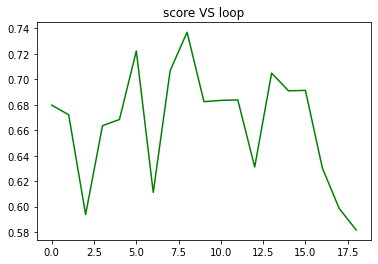

----现在进行第 17 轮筛选-----
|  选出数据池的index  |  数据池剩余   |   the score   |
|--- [100  69   4] ---|--- 120 ---|--- 0.637 ---|
|--- [121  62  12] ---|--- 117 ---|--- 0.672 ---|
|--- [114  82  99] ---|--- 114 ---|--- 0.607 ---|
|--- [ 84 107  19] ---|--- 111 ---|--- 0.679 ---|
|--- [95 97 85] ---|--- 108 ---|--- 0.610 ---|
|--- [24 32 53] ---|--- 105 ---|--- 0.643 ---|
|--- [18  8 41] ---|--- 102 ---|--- 0.667 ---|
|--- [27 73 55] ---|--- 99 ---|--- 0.669 ---|
|--- [ 1 11 25] ---|--- 96 ---|--- 0.585 ---|
|--- [64 57 47] ---|--- 93 ---|--- 0.554 ---|
|--- [ 79 103  94] ---|--- 90 ---|--- 0.572 ---|
|--- [ 31  50 106] ---|--- 87 ---|--- 0.572 ---|
|--- [111   2  60] ---|--- 84 ---|--- 0.550 ---|
|--- [ 5 38 67] ---|--- 81 ---|--- 0.586 ---|
|--- [49 96 30] ---|--- 78 ---|--- 0.504 ---|
|--- [37 23 14] ---|--- 75 ---|--- 0.580 ---|
|--- [ 21   9 113] ---|--- 72 ---|--- 0.521 ---|
|--- [70 98 59] ---|--- 69 ---|--- 0.531 ---|
|--- [34 48 86] ---|--- 66 ---|--- 0.549 ---|
|--- [ 68 105  52] ---|--- 6

KeyboardInterrupt: 

In [37]:
# 打乱顺序10次
def data_shuffle(epoch,data,n):
    global score_list 
    global best_score_last
    global index_list
    
    
    for i in range(0,20): # 循环筛选8次
        score_list = []
        index_list = []
        data = shuffle(data)
        # 每次筛选是否重制最开始的epoch
        epoch = data_truth_train
        print('----现在进行第',i,'轮筛选-----')
        epoch, score = choose_data(epoch,data,n)
        score = '%.3f' % score
        # print(str('data/choose_data'+str(i)+'.csv'))
        epoch.to_csv(str('data_screening/choose_data_'+str(n)+'_'+str(i)+'_'+score+'.csv'))  # 保存第几轮赛选和对应的分数

data_shuffle(epoch,data,3)

## Validate the best dataset

In [58]:
# epoch.to_csv('data/active_learning_3_914.csv')
data_epoch = pd.read_csv('data_relative_error/best_data_set/choose_data_3_3_0.835.csv')
data_epoch.head()

,Unnamed: 0,Mn,Co,Cu,Ga,Ge,Nb,Ni,Si,Sn,...,B,Fe,Ag,element_B,Sb,Cr,Re,alpha,t1,t2
0,0,3.1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,2,0.0,0.0,0.0,-7.93,391.00,439.00
1,5,3.2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,...,0.0,0.0,0.0,2,0.0,0.0,0.0,-19.60,238.00,309.00
2,3,3.2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,...,0.0,0.0,0.0,2,0.0,0.0,0.0,-9.91,357.00,413.00
3,4,3.2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,...,0.0,0.0,0.0,2,0.0,0.0,0.0,-33.80,293.00,345.00
4,71,3.0,0,0.5,0.0,0.0,0.0,0.0,0.0,0.3,...,0.0,0.0,0.0,3,0.2,0.0,0.0,-18.13,248.42,294.03


In [79]:
data_truth_val.head()

,Mn,Co,Cu,Ga,Ge,Nb,Ni,Si,Sn,Zn,...,B,Fe,Ag,element_B,Sb,Cr,Re,alpha,t1,t2
1,3.1,0,0,0,0,0,0,0,0.4,0.5,...,0,0,0,2,0,0,0,-25.3,313,371
2,3.1,0,0,0,0,0,0,0,0.3,0.6,...,0,0,0,2,0,0,0,-29.7,330,381


In [60]:
alpha_new = data_epoch['alpha']

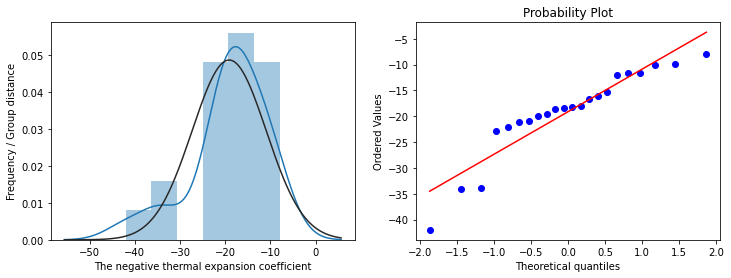

In [61]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(alpha_new.dropna(),fit=stats.norm,);
plt.ylabel("Frequency / Group distance")
plt.xlabel('The negative thermal expansion coefficient')
plt.subplot(1,2,2)
_ = stats.probplot(alpha_new.dropna(),plot=plt)

In [62]:
data_epoch.shape

(22, 23)

In [63]:
data_epoch = data_epoch[['Mn', 'Co', 'Cu', 'Ga', 'Ge', 'Nb', 'Ni', 'Si', 'Sn',
       'Zn', 'N', 'C', 'B', 'Fe', 'Ag', 'element_B', 'Sb', 'Cr', 'Re', 'alpha',
       't1', 't2']]
data_truth_val = data_truth_val[['Mn', 'Co', 'Cu', 'Ga', 'Ge', 'Nb', 'Ni', 'Si', 'Sn',
       'Zn', 'N', 'C', 'B', 'Fe', 'Ag', 'element_B', 'Sb', 'Cr', 'Re', 'alpha',
       't1', 't2']]

False
97
0.8356106613880678


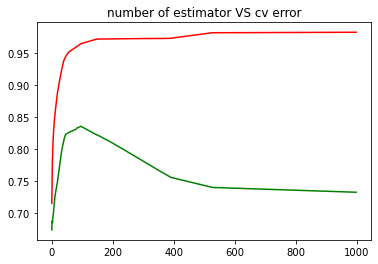

In [67]:
data_epoch = data_epoch.fillna(0)
print(data_epoch.isnull().any().any())

x = data_epoch.iloc[:,0:19]
y = data_epoch.iloc[:,19] 

standar = StandardScaler()
x1 = pd.DataFrame(standar.fit_transform(x))  # 对x做正则化

train_scores = []
test_scores = []
for i in range(1,1000,1):
    clf = SVR(C=i)
    train, test = kfold_relative_error(clf,x1,y)
    train_scores.append(train)
    test_scores.append(test)
plt.plot(test_scores, color='green',label="test")
plt.plot(train_scores, color='red',label='train')
plt.title("number of estimator VS cv error")
best_c = test_scores.index(max(test_scores))+1
print(best_c)
print(np.max(test_scores))

In [80]:
x_test = data_truth_val.iloc[:,0:19]
y_test = data_truth_val.iloc[:,19]
x_test = pd.DataFrame(standar.fit_transform(x_test)) 
clf = SVR(C=best_c)
clf.fit(x,y)
y_test_predict = clf.predict(x_test)
print(y_test,y_test_predict)

1   -25.3
2   -29.7
Name: alpha, dtype: float64 [-23.64113101 -28.42928416]


## Calculating manual sample performance

In [74]:
data_truth_val = pd.read_excel('data_arti_choose_new.xlsx')
data_truth_val = data_truth_val[['Mn', 'Co', 'Cu', 'Ga', 'Ge', 'Nb', 'Ni', 'Si', 'Sn',
       'Zn', 'N', 'C', 'B', 'Fe', 'Ag', 'element_B', 'Sb', 'Cr', 'Re']]

In [75]:
clf = SVR(C=best_c)
clf.fit(x1,y)

x_val = data_truth_val.iloc[:,0:19]
# y_val = data_truth_val.iloc[:,19]
standar = StandardScaler()
x_val = pd.DataFrame(standar.fit_transform(x_val))
y_pre = clf.predict(x_val)
for i in y_pre:
    print(i)

-32.92774819671989
-32.70651654800717
-30.877996409436882
-27.724645037679124
-23.81367477585111
-19.830305690438177
-16.381697825270304
-13.84854673210409
-33.58693368085071
-32.573798423524536
-29.996888312391626
-26.30063529101513
-22.151545856738807
-18.241863716099278
-15.101548410152347
-20.220640195409242
-16.67020291486696
-28.209324622909886
-31.326747185061155
-33.06781316422705
-24.276054469341027
-31.46290271673008
-29.182568401409753
-25.81881825170507
-21.980356704382558
-18.313918171049163
-29.04409242936117
-26.49111386300819
-23.193526191132356
-19.736688765966537
-26.18787818828338
-23.64206802056749
-20.674387031146058
-23.280189003917965
-20.97419397817563
-20.633612556569155
-31.203433924657634
-31.70159220889055
-30.697532890222625
-28.299475494636475
-24.92400918639028
-21.17782576092362
-17.67956089336174
-14.893560665066971
-13.036608302534875
